In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.integrate import odeint

import numdifftools as nd

In [11]:
#class for a single molecule species
class Species:
    # initialize species, make it aware of parent reaction system
    def __init__(self, system, name, constant=False):
        # system of the species 
        self.system = system
        self.name = name
        self.constant = constant
        
        # equation which describes the first time derivative of the species 
        self.equation = "0"
        # components of the different reactions, which constitute the time derivative
        self.components = ["0"]
        # function dt(X,P) which returns the calculated gradient
        self.dt = None
        
        self.generateFunction()
        
    # generate time derivative from components
    def generateFunction(self):
        self.equation = 'lambda X, P: ' + " + ".join(self.components)
        self.dt = eval(self.equation)
        
class Run: 
    def __init__(self,t,solution, model):
        self.time = t
        self.solution = solution
        self.model = model
        
    def plot(self):
        
        for i, species in enumerate(self.model.species):
            plt.plot(self.time,self.solution[:,i],label=species.name)
        plt.legend()
        #plt.show()
        
    def analyzeStability(self):
        jacobianF = nd.Jacobian(model.dX)
        jacobian = jacobianF(self.solution[-1,:],self.time[-1],np.array(self.model.parameters))
        print("===== STABILITY ANALYSIS =====\nThe stability analysis is only valid for steady states. \n")
        print("Jacobian at time={} ".format(self.time[-1]) )
        print(jacobian)
        eig_values, eig_vectors = np.linalg.eig(jacobian)
        print("\n")
        print("Eigen values")
        print(eig_values)
        print("\n")
        print("Eigen vectors")
        print(eig_vectors)
        print("\n")
        
        negReal = np.where(eig_values < 0)[0]
        zero = np.where(eig_values == 0)
        
        print(len(negReal),len(eig_values))
        
        if len(negReal) == len(eig_values):
            print("All eigenvalues have negative real parts, \nthe steady state is asymptotically stable")
        else:
            print("Not all eigenvalues have negative real parts, \nthe steady state is unstable") 
        
    #def phase(self):
        
        
class Model:
    def __init__(self):
        self.species = []
        self.parameters = []
        self.reactions = []
        self.loaded = False
        
    def getSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return s
        print("error: species " + name + " was not found")
        return None
    
    def indexSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return i
        print("error: species " + name + " was not found")
        return None
        
    def addSpecies(self, name, *args, **kwargs):
        self.species.append(Species(self, name, *args, **kwargs))
        
    def addReaction(self, reactants, stoichometry, k, kinetic_dependencies, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "stoichometric", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": kinetic_dependencies,
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "k"})
        self.parameters.append(k[0])
        
        self.reactions.append(reaction)
        
        parameter = "P[{}]".format(len(self.parameters)-1)
        
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        order = len(kinetic_dependencies)
        
        nth = " * " if order > 0 else ""
        v = parameter + nth +  "*".join(species)
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addMichaelisKinetics(self, reactants, stoichometry, k, reaction_id, reaction_comment):
        
        reaction = {
            "id": reaction_id, 
            "type": "Michaelis Menten kinetics", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": [],
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        self.parameters.append(k[0])
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_m"})
        self.parameters.append(k[1]) #K_m
        
        self.reactions.append(reaction)
        
        V_max = "P[{}]".format(len(self.parameters)-2)
        K_m = "P[{}]".format(len(self.parameters)-1)
        
        
        limiting_substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        
        v = V_max + " * " + limiting_substrate + " /(" + K_m + " + " +  limiting_substrate + ")"
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
        
    def addHillKinetics(self, reactants, stoichometry, k, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "hill-enzyme-kinetic", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": [],
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        V_max = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[0]) #hill_coefficent
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_a"})
        K_a = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[1]) #K_a
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "hill coefficient"})
        hill_coefficent = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[2]) #k_cat
        
        self.reactions.append(reaction)
        
        
        substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        
        v = V_max+ " *(" + substrate + "**" +  hill_coefficent + ")/(" + K_a + "**" + hill_coefficent + " + "+ substrate + "**" +  hill_coefficent + ")"
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addInhibitoryKinetics(self, reactants, stoichometry, k, kinetic_dependencies, reaction_id, reaction_comment):
        reaction = {
            "id": reaction_id, 
            "type": "Michaelis Menten kinetic with noncompetetive inhibition", 
            "description": reaction_comment ,
            "reactants": reactants,
            "stoichometry": stoichometry,
            "kinetic_dependencies": kinetic_dependencies,
            "parameters": []
            }
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "V_max"})
        V_max = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[0]) #k_cat
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_m"})
        K_m = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[1]) #K_m
        
        reaction["parameters"].append({"id": len(self.parameters), "name": "K_i"})
        K_i = "P[{}]".format(len(self.parameters))
        self.parameters.append(k[2]) #K_i
        
        self.reactions.append(reaction)
        
        inhibitor = "X[{}]".format(self.indexSpecies(kinetic_dependencies[0]))
        substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        
        v = V_max + " * " + substrate + " /((" + K_m + " + " +  substrate + ")"
        v += " *(1+" + inhibitor +"/"+ K_i +"))" 
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
        
    def dX(self, X,t, P):
        dX = np.array([species.dt(X,P) for species in self.species])
        return dX
    
    def load(self, path):
        if self.loaded:
            print("warning: model will be overwritten")
            self.species = []
            self.parameters = []
                  
        with open (path, "r") as myfile:
            data=myfile.readlines()
    
        reaction_id = 0
        # read model from system definition
        for i, line in enumerate(data):
            #remove newline and spaces
            line = line.strip("\n")
            


            # match first line for species definition
            if i == 0:
                species_match = re.findall('\$?[A-Z]+', line)
                if species_match:
                    for species in species_match:
                        if species[0] == "$":
                            self.addSpecies(species[1:], constant=True)
                        else:
                            self.addSpecies(species)
                else:
                    print("error: no species found in first line of system definition")

            #match consecutive lines for reaction equations
            else:
                if len(line) > 0 and line[0] != "#":
                    
                                   
                    reaction_match = re.findall(r"(.+)?-([A-Z])-(.*)->([0-9A-Z+ ]+)?(?:#(.*))?$",line)
                   
                    
                    if len(reaction_match) > 0:
                        reaction_id += 1
                        
                        educts = reaction_match[0][0]
                        reaction_type = reaction_match[0][1]
                        reaction_constants = reaction_match[0][2]
                        products = reaction_match[0][3]
                        
                        reaction_comment = reaction_match[0][4] 
                        
                        
                        
                        #match reaction constants and dependencies
                        constants = re.findall("(\d*\.?\d+)", reaction_constants)

                        if(len(constants) > 0):
                            constants = [float(i) for i in constants]
                            kinetic_dependencies = re.findall('[0-9]*[A-Z]+', reaction_constants)
                            reaction_order = len(kinetic_dependencies)

                        else: 
                             print("error: reaction constant was missing")

                        #match products and educts
                        educt_species = re.findall('[0-9]*[A-Z]+', educts)
                        product_species = re.findall('[0-9]*[A-Z]+', products)
                    
                        reactants = []
                        stoichometry = []

                        for educt in educt_species:

                            s = re.findall('[0-9]+', educt)
                            N = 1 if len(s) == 0 else int(s[0])
                            name = re.findall('[A-Z]+', educt)[0]

                            if name in reactants:
                                stoichometry[reactants.index(name)] -= N
                            else:
                                reactants.append(name)
                                stoichometry.append(-N)

                        for product in product_species:

                            s = re.findall('[0-9]+', product)
                            N = 1 if len(s) == 0 else int(s[0])
                            name = re.findall('[A-Z]+', product)[0]

                            if name in reactants:
                                stoichometry[reactants.index(name)] += N
                            else:
                                reactants.append(name)
                                stoichometry.append(N)

                        #stoichometric reaction        
                        if reaction_type == "S":

                            self.addReaction(reactants,stoichometry,constants, educt_species, reaction_id, reaction_comment)      

                        #reaction with michaelis menten kinetics
                        if reaction_type == "M":

                            if len(educt_species) > 1:
                                print("warning: michaelis menten kinetics with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")

                            self.addMichaelisKinetics(reactants,stoichometry,constants, reaction_id, reaction_comment)      
                            print(constants,kinetic_dependencies)
                            
                        #reaction with michaelis menten kinetics
                        if reaction_type == "H":
                            if len(educt_species) > 1:
                                print("warning: hill kinetic with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")
                                
                            self.addHillKinetics(reactants,stoichometry,constants, reaction_id, reaction_comment)
                            
                            print(reactants,stoichometry,constants,kinetic_dependencies)
                        
                        
                        if reaction_type == "I":
                            if len(educt_species) > 1:
                                print("warning: inhibitory kinetic with more than one substrate specified. species " + educt_species[0] +" will be choosen as rate limiting.")
                                
                            self.addInhibitoryKinetics(reactants,stoichometry,constants,kinetic_dependencies, reaction_id, reaction_comment)
        
    #move to simulation run class
    def simulate(self,X0,duration):
        t = np.linspace(0,duration,1000)
        solution = odeint(self.dX,X0,t,args=(model.parameters,))
        
        
        return(Run(t,solution,self))
    
    def explain(self):
        print("===== ODE Kinetic model  =====\n")
        print("the following species were defined: \n")
        
        for species in self.species:
            print("{:<8}".format(species.name))
            
                
        
        print("\nthe following reactions were defined:")
        
        for reaction in self.reactions:
            print("\n{}: ".format(reaction["id"]) + reaction["type"])
            print("reaction partner :" + ", ".join(reaction["reactants"]))
            print("stoichometry     :" + ", ".join(str(x) for x in reaction["stoichometry"]))
            print("dependency       :" + ", ".join(reaction["kinetic_dependencies"]))
            print("parameters       :")
            
            for parameter in reaction["parameters"]:
                print("   {:<6}".format(parameter["name"]) + ": {}".format(model.parameters[parameter["id"]]))
        
    

[1.0, 2.0, 5.0] []
['C', 'D'] [-1, 1] [4.0, 2.0, 5.0] []
===== ODE Kinetic model  =====

the following species were defined: 

A       
B       
C       
D       

the following reactions were defined:

1: Michaelis Menten kinetic with noncompetetive inhibition
reaction partner :A, B
stoichometry     :-1, 1
dependency       :D
parameters       :
   V_max : 0.5
   K_m   : 2.0
   K_i   : 2.0

2: Michaelis Menten kinetics
reaction partner :B, C
stoichometry     :-1, 1
dependency       :
parameters       :
   V_max : 1.0
   K_m   : 2.0

3: hill-enzyme-kinetic
reaction partner :C, D
stoichometry     :-1, 1
dependency       :
parameters       :
   V_max : 4.0
   K_a   : 2.0
   hill coefficient: 5.0

4: Michaelis Menten kinetic with noncompetetive inhibition
reaction partner :D, A
stoichometry     :-1, 1
dependency       :A
parameters       :
   V_max : 0.5
   K_m   : 2.0
   K_i   : 2.0


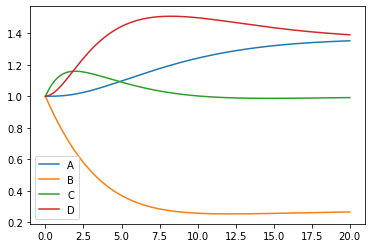

===== STABILITY ANALYSIS =====
The stability analysis is only valid for steady states. 

Jacobian at time=20.0 
[[-0.08900197  0.          0.          0.08701021]
 [ 0.0525067  -0.38940878  0.         -0.03509435]
 [ 0.          0.38940878 -0.5697024   0.        ]
 [ 0.03649527  0.          0.5697024  -0.05191585]]


Eigen values
[-6.36915136e-01+0.j          5.59890811e-15+0.j
 -2.31556931e-01+0.09932414j -2.31556931e-01-0.09932414j]


Eigen vectors
[[-0.10985559+0.j          0.6986049 +0.j         -0.33886874-0.23610434j
  -0.33886874+0.23610434j]
 [ 0.12139278+0.j          0.02979677+0.j         -0.24749881+0.07719609j
  -0.24749881-0.07719609j]
 [-0.70331035+0.j          0.02036699+0.j         -0.23834353+0.15890824j
  -0.23834353-0.15890824j]
 [ 0.69177316+0.j          0.71459676+0.j          0.82471107+0.j
   0.82471107-0.j        ]]


3 4
Not all eigenvalues have negative real parts, 
the steady state is unstable


In [3]:
model = Model()
model.load("system.txt")
model.explain()

index = model.reactions[0]["parameters"][0]["id"]



X0 = [1, 1, 1, 1]
run = model.simulate(X0,20)
run.plot()
run.analyzeStability()

[1.0, 2.0, 5.0] []
['C', 'D'] [-1, 1] [4.0, 2.0, 5.0] []
[0.5, 2.0, 2.0, 1.0, 2.0, 4.0, 2.0, 5.0, 0.5, 2.0, 2.0]
[1, 2.0, 2.0, 1.0, 2.0, 4.0, 2.0, 5.0, 0.5, 2.0, 2.0]


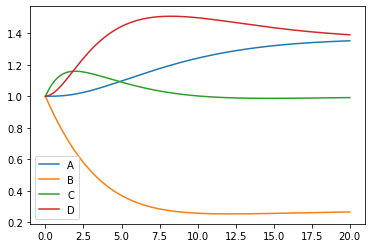

In [9]:
model = Model()
model.load("system.txt")
#print("\n\n")
print(model.parameters)

model.parameters[0]= 1
print(model.parameters)
model.parameters[0]= 0.5

X0 = [1, 1, 1, 1]
run = model.simulate(X0,20)
#model.parameters[0]= model.parameters[0] + 1
run.plot()
#P = 5
#model.dX(model.species,1, model.parameters)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


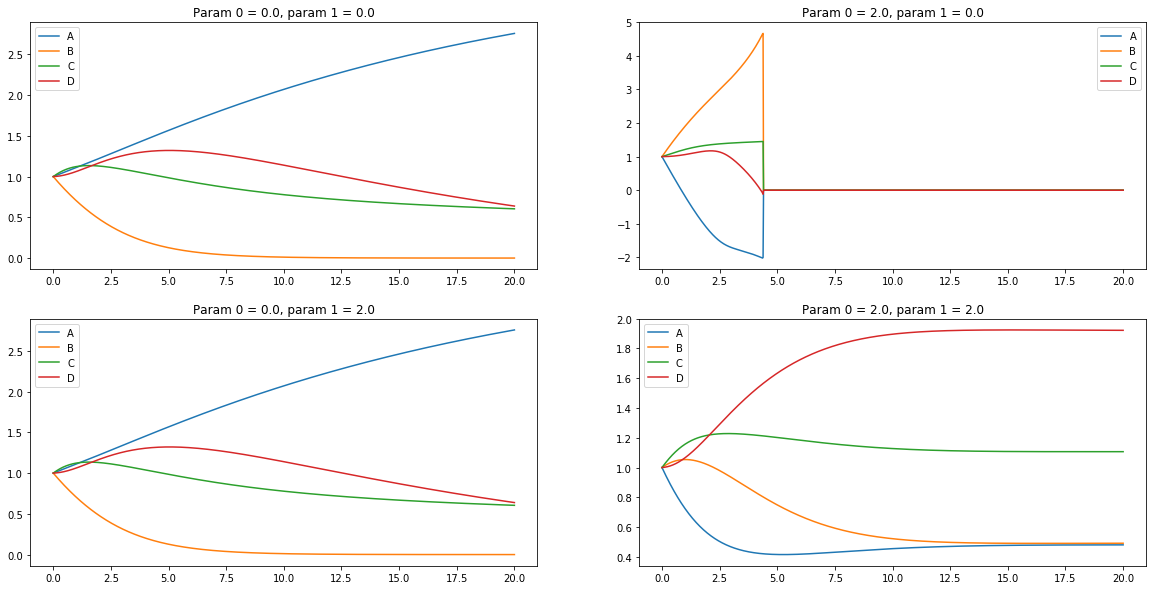

In [22]:

X0 = [1, 1, 1, 1]
A,B = np.meshgrid(np.linspace(0,2,lA), np.linspace(0,2,lB))
V = np.dstack((A,B))

lA = 2
lB = 2

count = 1
plt.figure(figsize=(20,10))
for i in range(lA):
    for j in range(lB):
        model.parameters[0] = V[i][j][0]
        model.parameters[1] = V[i][j][1]
        plt.subplot(lB, lA, count)
        plt.title("Param 0 = " + str(V[i][j][0]) + ", param 1 = " + str(V[i][j][1]))
        run = model.simulate(X0,20)
        run.plot()
        count = count +1
plt.show()

In [21]:
print(V)

[[[0. 0.]
  [2. 0.]]

 [[0. 2.]
  [2. 2.]]]


In [51]:
#(np.linspace(0,2,lA), np.linspace(0,2,lB)
def scan(A, B):
    lA = len(A)
    lB = len(B)
    tmp1, tmp2 = np.meshgrid(A, B)
    V = np.dstack((tmp1,tmp2))
    print (V)
    plt.figure(figsize=(20,10))
    count = 1
    for i in range(lA):
        for j in range(lB):
            # Hier kann dann noch ne schleife hin
            model.parameters[0] = V[i][j][0]
            model.parameters[1] = V[i][j][1]
            plt.subplot(lA, lB, count)
            plt.title("Param 0 = " + str(V[j][i][0]) + ", param 1 = " + str(V[j][i][1]))
            run = model.simulate(X0,20)
            run.plot()
            count = count +1
    plt.show()

[[[0.   0.  ]
  [0.75 0.  ]
  [1.5  0.  ]]

 [[0.   0.75]
  [0.75 0.75]
  [1.5  0.75]]

 [[0.   1.5 ]
  [0.75 1.5 ]
  [1.5  1.5 ]]]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


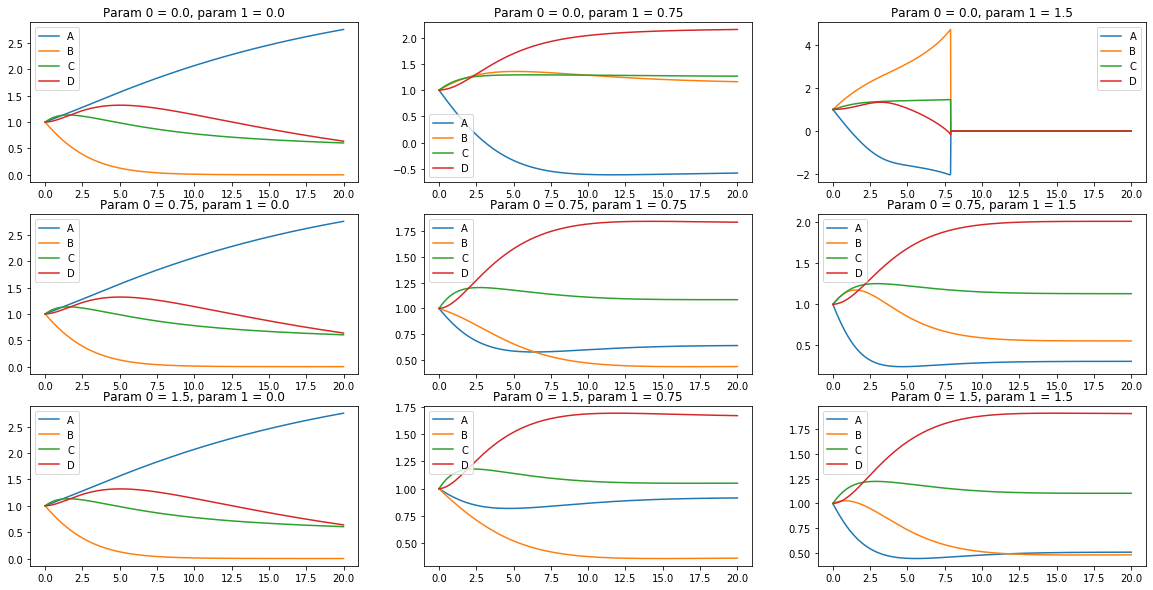

In [54]:
scan(np.linspace(0,1.5,3), np.linspace(0,1.5,3))

In [29]:
test = np.linspace(0,2,2)
print(test)

[0. 2.]


# Phasendiagramm

als P werden alle Parameter übergeben, anschließend aufruf von dX gibt es zurück

In [56]:
model = Model()
model.load("system.txt")
#print("\n\n")
#print(model.parameters)

#model.parameters[0]= 1
#print(model.parameters)
#model.parameters[0]= 0.5

t=1

X0 = [1, 1, 1, 1]
model.dX(X0,t,model.parameters)
# Damit müsste das dann aufzustellen gehen

#run = model.simulate(X0,20)



[1.0, 2.0, 5.0] []
['C', 'D'] [-1, 1] [4.0, 2.0, 5.0] []


array([ 0.        , -0.22222222,  0.21212121,  0.01010101])

# Sampling
simpler sampling ansatz: Generieren von zufälligen Werten für die parameter in Intervall.
Hierbei ist die Frage was als intervall angegeben wird.

Problem: Möglichkeit von häufungen der Punkten

# Besprechung/Orga

## Heatmap

* Schrittweises berechnen mit unterschiedlichen Parametern (grid/sampling)
* Alle X Zeitrschritte Änderung zum vorherigen Schritt berechnen (Änderungsrate)
* Änderungsrate ausgeben
* Wenn festgelegtes Delta überschritten, nächste Iteration
* Wenn alle Parameter unter Delat Abweichung oder 100(o.ä.) Zeitschritte berechnet stoppen
* Ergebnis als Heatmap ausgeben